In [3]:
from tqdm.notebook import tqdm as tqm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
from math import pi
import wave 

plt.style.use('ggplot')

from scipy import fft
import pyfftw as fftw
# Opciones de matplotlib
rc=plt.rcParams
rc['figure.figsize']=[10,4]

# Para mostrar todas las columnas cuando se imprime un df
pd.set_option('display.max_columns', None)

Vemos una señal como se emite desde la fuente o percibida por un sólo micrófono

In [5]:
div=100
n_ventana=1024
freq_sampleo=48_000

T=n_ventana/freq_sampleo
t=np.linspace(0,T,num=div)
s1=np.sin(2*np.pi/T*t)

fig=px.line(x=t,y=s1,markers=True)

fig.update_layout(
    title='señal 1',xaxis_title='t', yaxis_title='s(t)',
    height=300, width=400, template='plotly_dark'
)

fig.show()


Las frecuencias que tiene la transformada de Fourier dividen el espacio que hay entre la frecuencia de NS al 0 entre la mitad de las muestras en el espacio temporal. También se refleja la frecuencia para incluir términos negativos. 

In [6]:
# Armamos el arreglo de frecuencias

def arreglo_frecuencias(freq_sampleo,n_ventana):
    
    f_NS=freq_sampleo//2
    freq_array=np.zeros(n_ventana)
    f1=freq_sampleo/n_ventana
    for i in range(1,len(freq_array)//2):
        freq_array[i]=f1*i 
        freq_array[len(freq_array)-i]=-freq_array[i]
    freq_array[n_ventana//2]=f_NS
    return freq_array



La señal tiene una frecuencia de muestreo de $48,000 \text{ Hz}$ y estamos tomando sólo 100 muestras, entonces las frecuencias van desde 0 hasta $$ f_{NS}=\frac{48,000}{2}\text{ Hz}=24,000\text{ Hz}$$
y está dividida en un intervalo de 50 por la izquierda y 50 por la derecha.


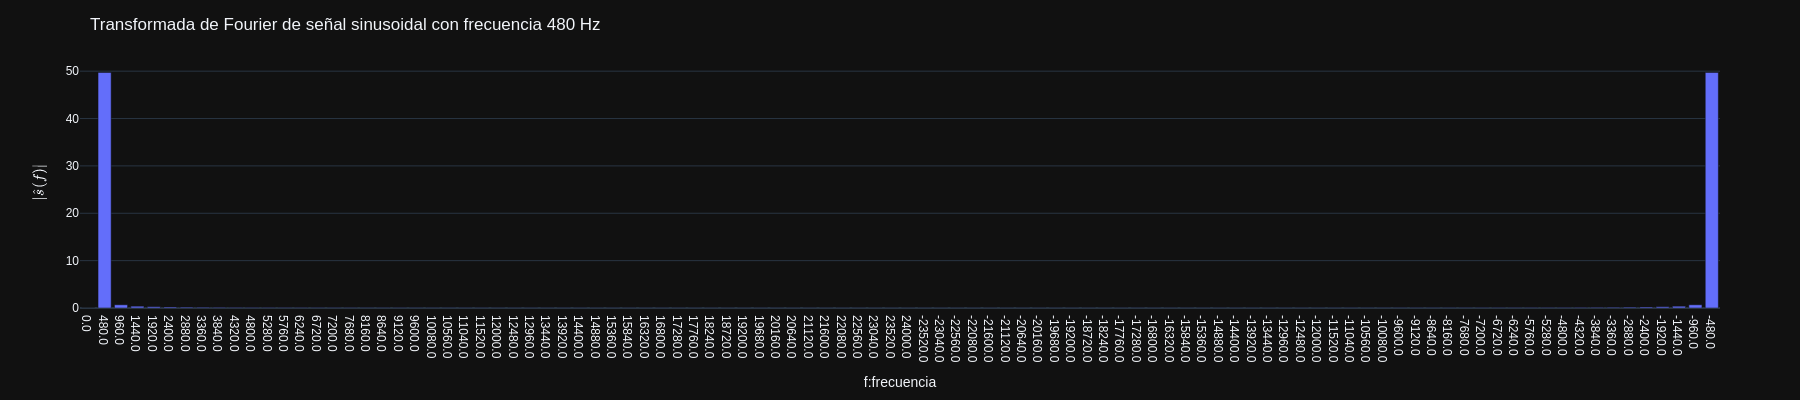

In [23]:
s_hat=np.abs(fft.fft(s1))

freq_array=arreglo_frecuencias(freq_sampleo,n_ventana=div)
freq_array_string=[str(fi) for fi in freq_array]
fig=px.bar(x=freq_array_string,y=s_hat)

fig.update_layout(
    title=f'Transformada de Fourier de señal sinusoidal con frecuencia {int(freq_array[1])} Hz',xaxis_title='frecuencia', yaxis_title='$|\hat{s}(f)|$',
    height=400, width=1800, template='plotly_dark'
)

fig.show(renderer='png')

# Recreando el archivo de `music_multicomplete.m`

Creamos señales y su salida a los respectivos micrófonos de acuerdo a los parámetros. Se tienen tres micrófonos en **arreglo lineal** y dos señales sinusoidales con diferentes frecuencias

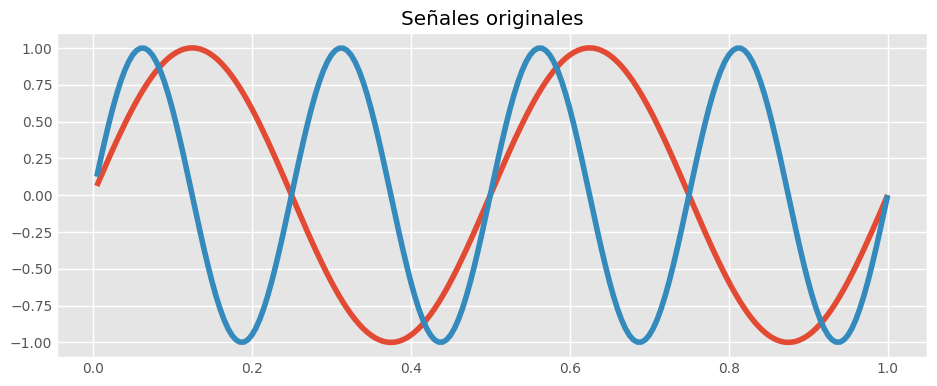

In [26]:
DOAS=[-30,40] # DOA en grados
d_im=20 # distancia inter-micrófono, arreglo lineal
K=200 # Tamaño de señal en sampleo, también es la frecuencia de sampleo
n_ventana=K
freq_sampleo=K

freq_array=arreglo_frecuencias(freq_sampleo,n_ventana)
freq_array_string=[str(fi) for fi in freq_array]

freqs=[2,4] # frecuencia de las señales
c=343 # Velocidad del sonido
t=np.linspace(1,K,num=K)/K

N_mic=3
n_ruidoso=2 

s1=np.sin(2*np.pi*freqs[0]*t)
s2=np.sin(2*np.pi*freqs[1]*t)

plt.title('Señales originales');plt.plot(t,s1,label='Señal 1');plt.plot(t,s2,label='Señal 2');plt.show()

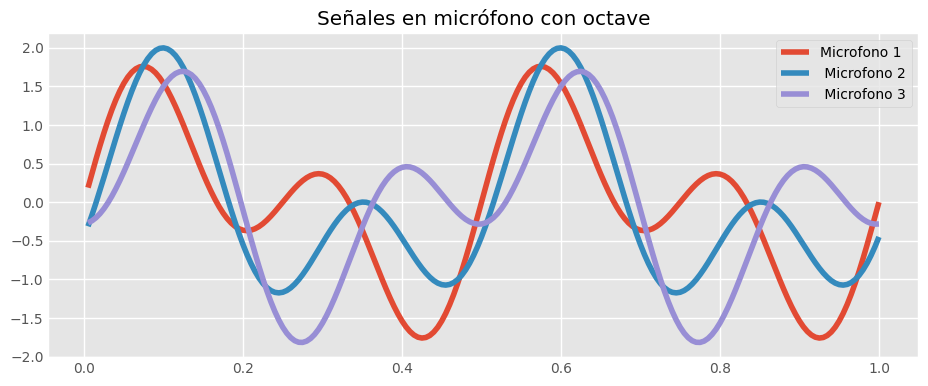

In [27]:
k=np.array([-2*pi*d_im/c*np.sin(di*pi/180) for di in DOAS]) # el exponente de cada exp por el que hay que multiplicar la transformada con la frecuencia para que dé el tensor S
# np.exp(-2*pi*1j)

x=s1+s2
y=fft.ifft(fft.fft(s1)*np.exp(k[0]*freq_array*1j)).real+fft.ifft(fft.fft(s2)*np.exp(k[1]*freq_array*1j)).real
z=fft.ifft(fft.fft(s1)*np.exp(2*k[0]*freq_array*1j)).real+fft.ifft(fft.fft(s2)*np.exp(k[1]*2*freq_array*1j)).real
plt.title('Señales en micrófono con octave')
plt.plot(t,x,label='Microfono 1')
plt.plot(t,y,label=' Microfono 2')
plt.plot(t,z,label=' Microfono 3')
plt.legend()
plt.show()

## Usando matrices
Hacemos el mismo cálculo usando la construcción de tensores que se utiliza en **MUSIC**. Para comprobar que funciona, se compara con la gráfica anterior.

La ecuación matricial que define cómo está relacionada la señal recibida por los $N_{mics}$ micrófonos con la emitida por las $N_{sign}$ señales (por cada frecuencia) está dada por

$$ {X^{(f)}}_{(N_{mics}\times 1)}={\mathbf{A}^{(f)}}_{(N_{mics}\times N_{sign})} {S^{(f)}}_{(N_{sign}\times 1)}$$

donde 
- ${X^{(f)}}_{(N_{mics}\times 1)}$ es la  señal recibida por los micrófonos
- ${\mathbf{A}^{(f)}}_{(N_{mics}\times N_{sign})}=\left( \mathbf{a}^{(\theta_1)},\cdots \mathbf{a}^{(\theta_{N_{sign}})} \right)$ es la matriz de steering vectors, uno por columna.
    - Los steering vectors nos dicen el desfase del micrófono de la señal relativo al micrófono de referencia. ${{a}^{(\theta_{N_{sign}})}}_{(N_{mics}\times 1)}$, donde el ángulo con respecto al micrófono de referencia dicta el desfase dependiendo de la geometría del arreglo
- ${S^{(f)}}_{(N_{sign}\times 1)}$ es la señal emitida por cada una de las fuentes. Es el objetivo de la tarea de separación de fuentes.

Para una arreglo lineal, los steering vectors están dados por la matriz de vandermonde del factor de desfase debido a una distancia de separación de $d_{im}$


In [28]:
def a_theta_f(θ,f,N_mic=N_mic,d_im=d_im,c=c):
    '''
    Genera los steering vector en la dirección θ para un arreglo lineal de N_mic micrófonos y una frecuencia fija
    '''
    k=-2*pi*d_im/c*np.sin(θ*pi/180)
    a=[np.exp(k*f*ni*1j) for ni in range(N_mic)]
    return np.array(a)

def A_f(θs,f,N_mic=N_mic,d_im=d_im,c=c):
    '''
    Para arreglo lineal. Función que genera la matriz de steering vectors para una frecuencia específica con varias fuentes ubicadas en θs
    '''
    A=np.zeros(shape=(N_mic,len(θs)))+0j
    for i in range(len(θs)):
        A[:,i]=a_theta_f(θs[i],f,d_im=d_im,c=c)
    
    return A


def A_completa(θs,freqs,N_mic=N_mic,d_im=d_im,c=c):
    '''
    Para arreglo lineal. 
    Calcula el tensor A para las frecuencias requeridas apliando matrices de steering vectors
    '''
    A=np.zeros(shape=(len(freqs),N_mic,len(θs)))+0j
    for i in range(len(freqs)):
        A[i,:,:]=A_f(θs,freqs[i],d_im=d_im,c=c)
    
    return A


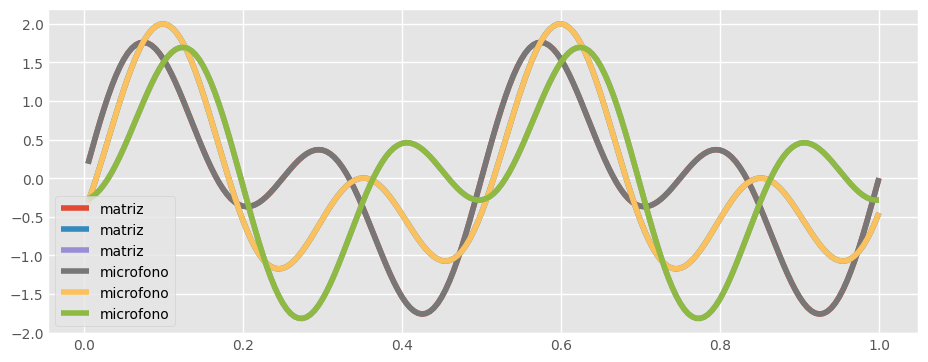

In [32]:

# Comprobación con datos de señales entrantes
s_t=[s1,s2]
s_vec=s_t[0]
for i in range(1,len(s_t)):
    s_vec=np.c_[s_vec,s_t[i]]
# s_vec=np.c_[s_t]
s_vec=np.c_[s1,s2]

A=A_completa(θs=DOAS,freqs=freq_array)
s_vec=np.c_[s1,s2]
s_hat_vec=fft.fft(s_vec,axis=0)
x_mics=np.zeros((N_mic,len(freq_array)))+0j
for i in range(A.shape[0]):
    x_mics[:,i]=A[i,:,:]@s_hat_vec[i,:]
x_mics=fft.ifft(x_mics,axis=1).real

plt.plot(t,x_mics[0],label='matriz')
plt.plot(t,x_mics[1],label='matriz')
plt.plot(t,x_mics[2],label='matriz')

plt.plot(t,x,label='microfono')
plt.plot(t,y,label='microfono')
plt.plot(t,z,label='microfono')
plt.legend()
plt.show()

como sólo se ven tres gráficas confirmamos que se obtiene lo mismo

### Juntamos todo en una función

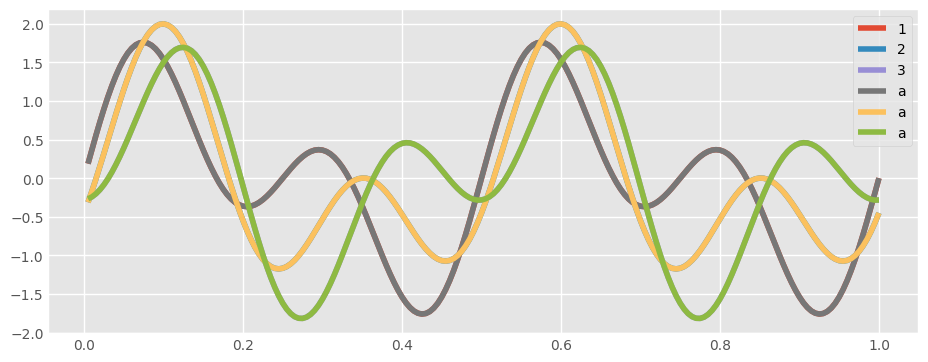

In [35]:
def gen_señales_mic(DOAS,señales,d_im,N_mic,n_ventana=1024,freq_sampleo=48_000):
    '''
    Para un arreglo lineal
    regresa las señales  que se observarían en cada micrófono dadas las señales 

    DOAS: Los ángulos en grados de las señales de entrada 
    d_im: distancia inter-micrófono
    n_ventana: el tamaño de la muestra 
    señales: funciones o arreglos que se le aplican a los datos 
    '''
    
    # Se obtienen las frecuencias de la transformada rápida
    freq_array=arreglo_frecuencias(freq_sampleo,n_ventana)
  
    # freq_array_string=[str(fi) for fi in freq_array]
    t=np.linspace(1,n_ventana,num=n_ventana)*(n_ventana/freq_sampleo)/n_ventana # Para que esté en un intervalo de un segundo 
    s_t=[s(t) for s in señales]
    # return s_t

    A=A_completa(DOAS,freqs=freq_array,d_im=d_im)

    s_vec=s_t[0]
    for i in range(1,len(s_t)):
        s_vec=np.c_[s_vec,s_t[i]]

    s_hat_vec=fft.fft(s_vec,axis=0)

    x_mics=np.zeros((N_mic,len(freq_array)))+0j
    for i in range(A.shape[0]):
        x_mics[:,i]=A[i,:,:]@s_hat_vec[i,:]
    x_mics=fft.ifft(x_mics,axis=1).real
    return t,x_mics

señales=[lambda x: np.sin(2*pi*freqs[0]*x),lambda x: np.sin(2*pi*freqs[1]*x)]

x_mics=gen_señales_mic(DOAS,señales,d_im,N_mic,K,K)[1]
plt.plot(t,x_mics[0],label='1')
plt.plot(t,x_mics[1],label='2')
plt.plot(t,x_mics[2],label='3')

plt.plot(t,x,label='a')
plt.plot(t,y,label='a')
plt.plot(t,z,label='a')
plt.legend()
plt.show()

# MUSIC Ejemplo de clase

Ya con las señales de micrófono en general, se puede
- Generar señales más complicadas que tengan más frecuencias
- Poner los parámetros del problema de JACK
- Dividir en ventanas para hacer wola y ver cómo se le va a hacer al problema en general

Pero antes de eso primero hay que tratar esto como si fuera una sóla ventana e ir haciendo el análisis de los estimadores de la función de covarianza

## Detectar DOAS en señal completa como si fuera una ventana usando music


Se tendría que buscar para todas las frecuencias, pero aquí ya sabemos que están en [2,4] porque las señales originales tienen 2 y 4 periodos respectivamente. 

Es diferente la frecuencia en la que se buscan las señales a desfasar y el ángulo de dirección

También se podría usar procesos gaussianos para ir buscando el ángulo, igual y no en vivo, pero te da la mejor dirección de búsqueda

In [36]:
fig=px.bar(x=freq_array_string,y=np.abs(s_hat_vec)[:,0])
fig.update_layout(
    title='Transformada para Señal 1',xaxis_title='f', yaxis_title='s1_hat(f)',
    height=500, width=900, template='plotly_dark',
)

fig.add_bar(x=freq_array_string,y=np.abs(s_hat_vec)[:,1],name='señal 2')
fig.show()



In [37]:
def MUSIC(this_ws,x_mics,angles,n_ruidoso):
    '''
    Función para encontrar el espectro de music. Depende del arreglo de micrófonos a través de A_completa
    x_mics: el arreglo de señales que ve cada micrófono
    '''
    X=fft.fft(x_mics,axis=1) # se hace la transformada a lo largo del eje 1 para obtener una transformada por cada mic
    music_spectrum=np.zeros(shape=(len(this_ws),len(angles)))
    for i,wi in enumerate(this_ws):
        this_X=X[:,wi] # TODO: Esta es la que tiene que ser calculada usando ventanas anteriores. Cuando dividas en varias ventanas de Hann, se debería de ver una diferencia en la estimación
        R=this_X.reshape(-1,1)*this_X.conj().T

        D,Q=np.linalg.eig(R)
        I=np.argsort(D.real)[::-1]
        D=D[I]
        Q=Q[:,I]


        # Qs=Q[:,1:n_ruidoso]
        Qn=Q[:,n_ruidoso:]

        A_angles=A_completa(θs=angles,freqs=[wi])

        for k in range(len(angles)):
            music_spectrum[i,k]=np.abs(1/(A_angles[0,:,k].conj().T@(Qn*Qn.conj().T@A_angles[0,:,k])))
    return music_spectrum


In [38]:

# Se seleccionan las componentes de las señales en el espacio de frecuencia que buscamos, no tienen que ver con el retraso sino con las señales de origen 
this_ws=[2,4,6,8]

angles=np.arange(-90,90,0.1) # Los ángulos para buscar ortogonalidad
# TODO: Probar con menos y ver exactamente dónde está el bottleneck

music_spectrum=MUSIC(this_ws,x_mics,angles,n_ruidoso)


In [39]:
def music_plot(angles,freq_array,music_spectrum,this_ws,DOAS,titulo='Music con ventana completa'):
    
    traces=[go.Scatter(x=angles,y=music_spectrum[i,:],mode='lines',name=f'Frecuencia {int(freq_array[wi])} Hz') for i,wi in enumerate(this_ws)]
    fig=go.Figure()
    [fig.add_trace(trace) for trace in traces]
    fig.update_layout(
        title=f'{titulo}',xaxis_title='x', yaxis_title='F(x)',
        height=500, width=900, template='plotly_dark'
    )
    for i,doa in enumerate(DOAS):
        fig.add_scatter(x=[doa,doa],y=[0,music_spectrum[:,:].max()],name=f'DOA {i}',mode='lines',line_color='white',line_dash='dash',line_width=3)
        pass
    fig.show()
    return

music_plot(angles,freq_array,music_spectrum,this_ws,DOAS=DOAS)


Sólo las direcciones de arribo correctas se calculan bien

## Detectar DOAS usando HANN con señal completa

Las señales de las ventanas no son periódicas y esto a veces ocasiona problemas en las transformadas de Fourier. Para arreglar esto se puede usar Hann, si se necesitara regresar al espacio del tiempo también se aplicaría una transformación periódica a la transformada, pero en este caso, el análisis de MUSIC ocurre todo en el espacio de frecuencia así que basta con usar hann

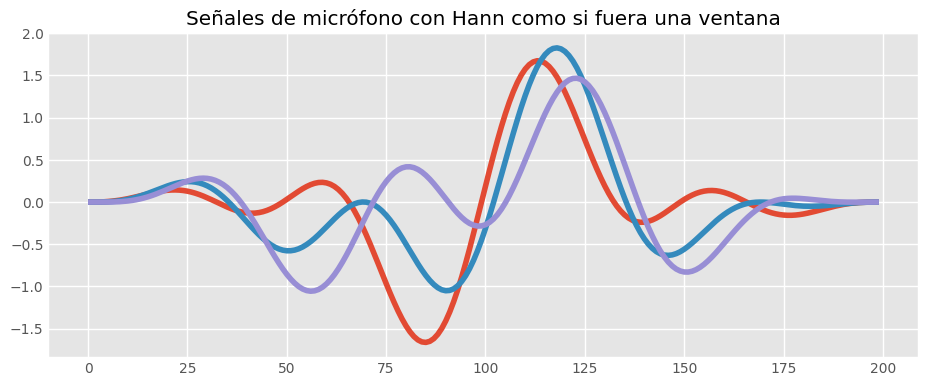

In [40]:
hann=lambda x:0.5*(1-np.cos(2*pi*np.linspace(0,1,x)))
hann_array=hann(200)


x_hann=x_mics*hann_array

plt.title('Señales de micrófono con Hann como si fuera una ventana')
plt.plot((x_hann)[0])
plt.plot((x_hann)[1])
plt.plot((x_hann)[2])
plt.show()
plt.show()

In [45]:
music_spectrum_hann=MUSIC(this_ws,x_hann,angles,n_ruidoso)
music_plot(angles=angles,music_spectrum=music_spectrum_hann,this_ws=this_ws,DOAS=DOAS,freq_array=freq_array,titulo='Music para Hann')

La diferencia es menos clara que cuando no se hace el Hann. Si se acerca a los picos se puede ver que tienen un ancho que no estaba en el procedimiento sin Hann.

## Detectar DOAS partiendo cada intervalo como si fuera una ventana 

Partimos nuestra señal de un segundo en ventanas de 1024 sampleadas con una frecuencia de 48000 Hz

In [46]:
t_ventanas,x_ventanas=gen_señales_mic(DOAS,señales,d_im,N_mic,n_ventana=48_000,freq_sampleo=48_000)
x_ventanas.shape

(3, 48000)

In [47]:
# Dividimos en ventanas de 1024
n_ventana=1024
freq_sampleo=48_000

t_v_array,x_v_array=[],[]

num_ventanas=freq_sampleo//n_ventana
for i in range(num_ventanas):
    t_v_array.append(t_ventanas[i*n_ventana:(i+1)*n_ventana])
    x_v_array.append(x_ventanas[:,i*n_ventana:(i+1)*n_ventana])

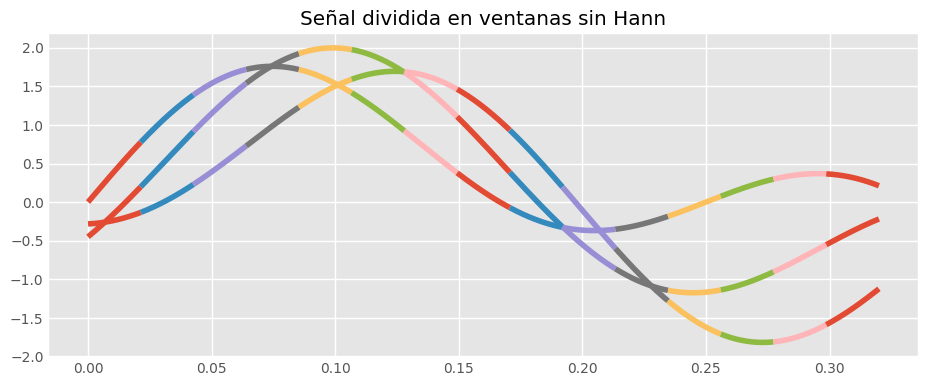

In [48]:
plt.title('Señal dividida en ventanas sin Hann')
for i in range(num_ventanas//3):
    plt.plot(t_v_array[i],x_v_array[i][0],c=sns.color_palette()[i%len(sns.color_palette())])
    plt.plot(t_v_array[i],x_v_array[i][1],c=sns.color_palette()[i%len(sns.color_palette())])
    plt.plot(t_v_array[i],x_v_array[i][2],c=sns.color_palette()[i%len(sns.color_palette())])

usando music en cada uno de los segmentos se obtiene

In [49]:
angs_max=[]
intens_max=[]
for ventana in range(num_ventanas):
    ms_ventana=MUSIC(this_ws,x_v_array[ventana],angles,n_ruidoso)
    idx_max=ms_ventana.argmax(axis=1)
    
    angs_max.append(angles[idx_max])
    intens_max.append(np.array([ms_ventana[i,idx_max[i]] for i in range(len(idx_max))]))

Distribución de los 4 ángulos máximos totales

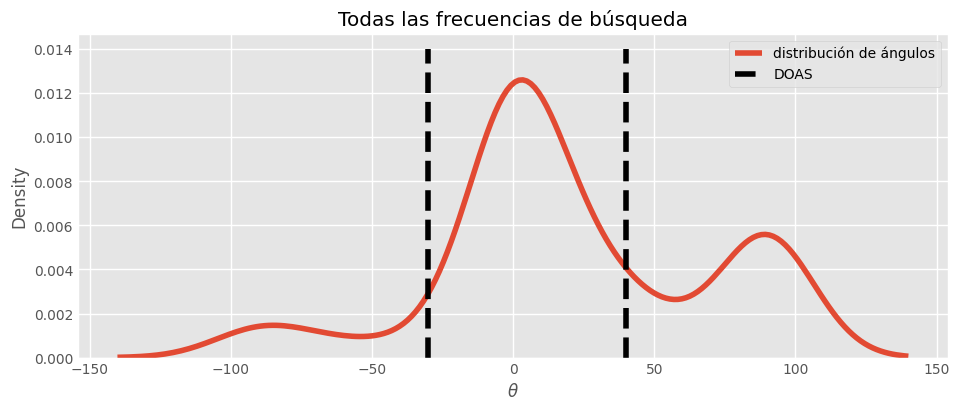

In [56]:
angulos_maximos=np.array(angs_max).reshape(-1)
plt.title('Todas las frecuencias de búsqueda')
sns.kdeplot(angulos_maximos,label='distribución de ángulos')
plt.vlines(x=DOAS,ymin=0,ymax=0.014,colors='k',label='DOAS',linestyles='dashed')
plt.xlabel('$\\theta$')
plt.legend()

Distribución de los top 2 ángulos

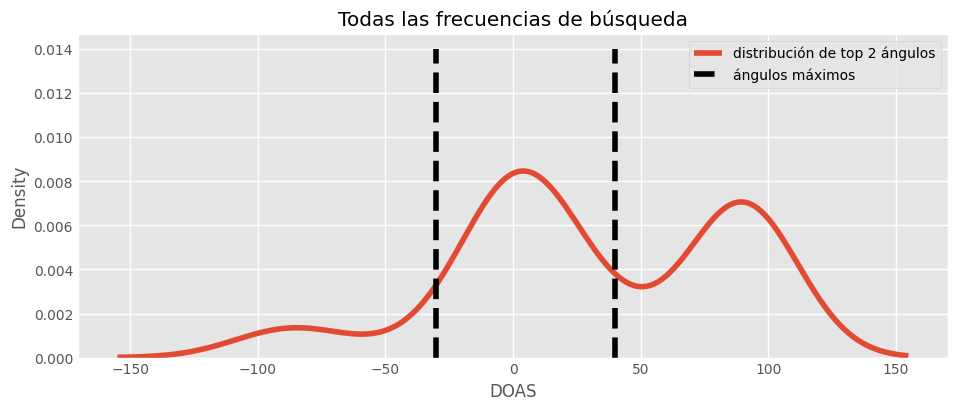

In [58]:
top_2_angs=[]
for a,i in zip(angs_max,intens_max):
    idx_int=np.argsort(i)
    top_2_angs.append(a[idx_int][:2])

angulos_maximos_2=np.array(top_2_angs).reshape(-1)
plt.title('Todas las frecuencias de búsqueda')
sns.kdeplot(angulos_maximos_2,label='distribución de top 2 ángulos')
plt.vlines(x=DOAS,ymin=0,ymax=0.014,colors='k',label='ángulos máximos',linestyles='dashed')
plt.xlabel('DOAS')
plt.legend()

Vemos que ninguno de los dos métodos arroja algo bueno

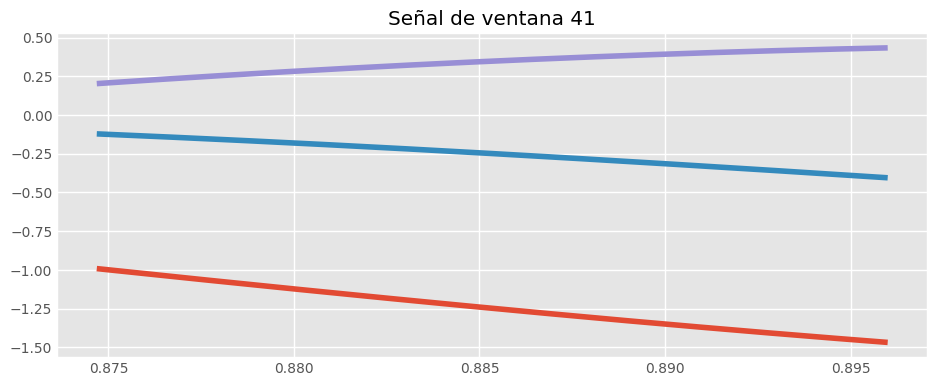

In [61]:
ventana_random=np.random.randint(0,num_ventanas-1)
music_random=MUSIC(this_ws,x_v_array[ventana_random],angles,n_ruidoso)
plt.title(f'Señal de ventana {ventana_random}')
plt.plot(t_v_array[ventana_random],x_v_array[ventana_random][0])
plt.plot(t_v_array[ventana_random],x_v_array[ventana_random][1])
plt.plot(t_v_array[ventana_random],x_v_array[ventana_random][2])
plt.show()
music_plot(angles= angles,music_spectrum= music_random ,this_ws=this_ws,DOAS=DOAS,freq_array=freq_array,titulo=f'Music para ventana {ventana_random}')

## Detectar DOAS partiendo cada intervalo como si fuera una ventana  con HANN


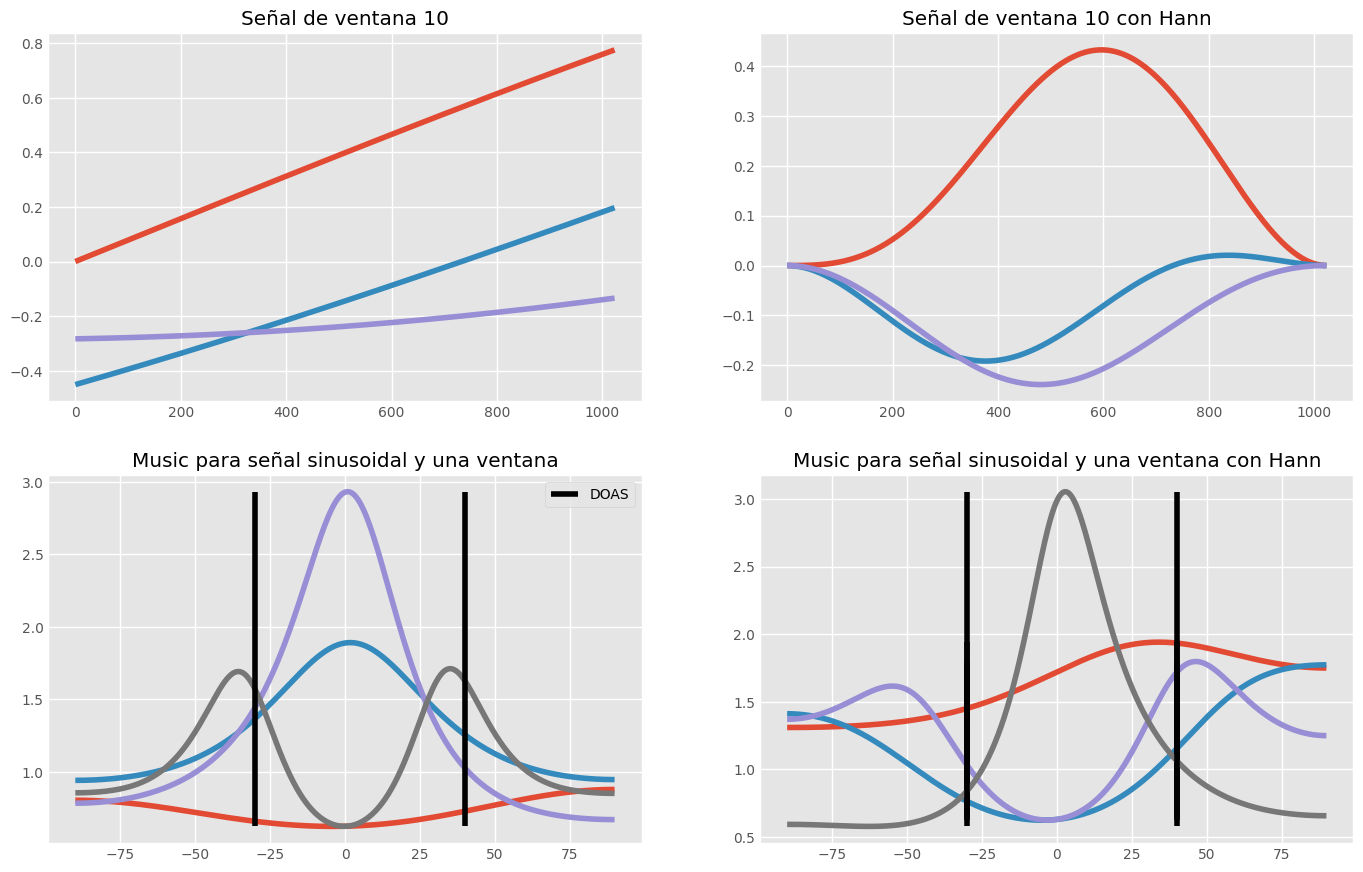

In [63]:
ventana_random=np.random.randint(0,num_ventanas-1)

hann=lambda x:0.5*(1-np.cos(2*pi*np.linspace(0,1,x)))
hann_array=hann(x_v_array[0].shape[1])



fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
ax[0,0].set_title(f'Señal de ventana {ventana_random}')
ax[0,0].plot((x_v_array[0])[0])
ax[0,0].plot((x_v_array[0])[1])
ax[0,0].plot((x_v_array[0])[2])


ax[0,1].set_title(f'Señal de ventana {ventana_random} con Hann')
ax[0,1].plot((x_v_array[0]*hann_array)[0])
ax[0,1].plot((x_v_array[0]*hann_array)[1])
ax[0,1].plot((x_v_array[0]*hann_array)[2])


music_random=MUSIC(this_ws,x_v_array[ventana_random],angles,n_ruidoso)

ax[1,0].set_title('Music para señal sinusoidal y una ventana')
for i in range(music_random.shape[0]):
    ax[1,0].plot(angles,music_random[i])
ax[1,0].vlines(DOAS,music_random.min(),music_random.max(),colors='k',label='DOAS')
ax[1,0].legend()

music_random_hann=MUSIC(this_ws,x_v_array[ventana_random]*hann_array,angles,n_ruidoso)

ax[1,1].set_title('Music para señal sinusoidal y una ventana con Hann')

for i in range(music_random.shape[0]):
    ax[1,1].plot(angles,music_random_hann[i])
    ax[1,1].vlines(DOAS,music_random_hann[i].min(),music_random_hann[i].max(),colors='k')

plt.show()

Agarramos las dos mayores intensidades de MUSIC, vemos sus ángulos (para con y sin Hann) y hacemos un histograma 

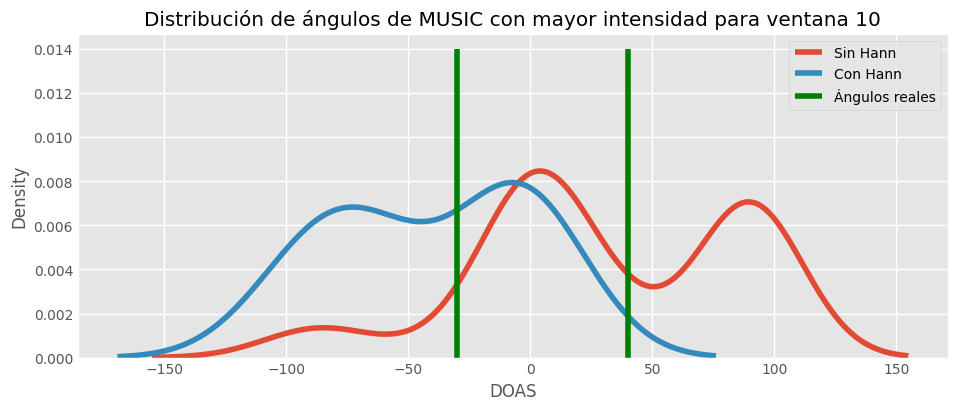

In [66]:
idx_maximos_hann2=np.argsort(music_random_hann,axis=1)[:,:2]
angulos_maximos_hann2=angles[idx_maximos_hann2]

plt.title(f'Distribución de ángulos de MUSIC con mayor intensidad para ventana {ventana_random}')
sns.kdeplot(angulos_maximos_2,label='Sin Hann')
sns.kdeplot(angulos_maximos_hann2.reshape(-1),label='Con Hann')
plt.vlines(x=DOAS,ymin=0,ymax=0.014,colors='g',label='Ángulos reales')
plt.xlabel('DOAS')
plt.legend(); plt.show()



# Leyendo archivo de AIRA

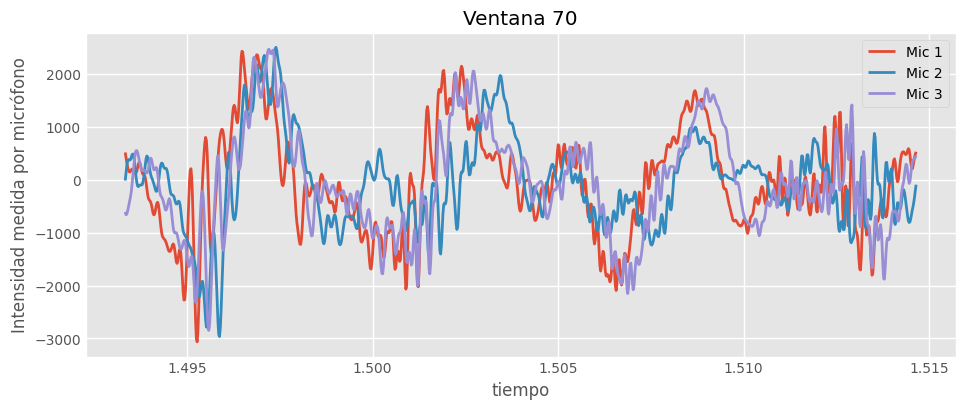

In [74]:
def leer_señal_array(path):
    wav_object=wave.open(f'{path}','rb')
    fr=wav_object.getframerate() # 48000 Hz
    ns=wav_object.getnframes() # 1539072


    signal_wave=wav_object.readframes(ns)
    signal_array=np.frombuffer(signal_wave,dtype=np.int16)
    
    return signal_array

wav_object=wave.open('../Programas PDA/6. AIRA/clean-2source/wav_mic1.wav','rb')
fr_AIRA=wav_object.getframerate() # 48000 Hz
ns_AIRA=wav_object.getnframes() # 1539072
T_AIRA=ns_AIRA/fr_AIRA # 32s
nchannels_AIRA=wav_object.getnchannels() # 1

ventana_estudio=70 # Abajo de esta ventana empieza a agarrar ruido real

mic_array_AIRA1=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/wav_mic1.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]
mic_array_AIRA2=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/wav_mic2.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]
mic_array_AIRA3=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/wav_mic3.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]

n_ventanas_AIRA=mic_array_AIRA1.shape[0]//n_ventana

lista_señales_AIRA=[mic_array_AIRA1,mic_array_AIRA2,mic_array_AIRA3]

time_AIRA=np.linspace(0,T_AIRA,num=ns_AIRA)[(1024*ventana_estudio):1024*(ventana_estudio+1)]


plt.title(f'Ventana {ventana_estudio}')
for i,li in enumerate(lista_señales_AIRA):
    plt.plot(time_AIRA,li,label=f'Mic {i+1}',linewidth=2)
plt.xlabel('tiempo'); plt.ylabel('Intensidad medida por micrófono')
plt.legend();plt.show()

## Cambiando A para ajustarse al arreglo triangular

Sabemos que la configuración de micrófonos de AIRA no es lineal, entonces tenemos que cambiar nuestros cálculos de los direction vectors. El arreglo está dado por 

![arr_AIRA](./imgs/arr_AIRA.png)



Para los dos primeros micrófonos es lo mismo, para el tercero es donde hay que cambiarlo. 

Como el triángulo entre los micrófonos es equilátero, el ángulo $$\theta_{m3}=\frac{\pi}{2}+\frac{\pi}{3}=\frac{5}{6}\pi$$

Así, el direction vector queda como 

$$ 
\begin{align}
{\vec{a}(\theta)}_{AIRA}^{f}=\begin{pmatrix}
1\\
e^{-if\frac{2\pi d}{c}\sin(\theta) }\\
e^{-if\frac{2\pi d}{c}\cos(\frac{5}{6}\pi-\theta)}
\end{pmatrix}

\end{align}
$$


In [144]:
dm_AIRA=0.18 # Separación de micrófonos en metros

def a_theta_f_AIRA(θ,freq,dm_AIRA=dm_AIRA,c=c):
    '''
    θ: Dirección de arribo con respecto a la referencia
    f: frecuencia de la señal
    dim: distancia entre micrófonos, para el arreglo de AIRA es el mismo porque es triángulo equilatero
    Genera los steering vector en la dirección θ para el arreglo triangular de AIRA
    '''
    θ_rad=θ*pi/180
    k=-2*pi*dm_AIRA/c*np.sin(θ_rad)
    a=[1+0j,np.exp(k*freq*1j)]
    a.append(np.exp(2*pi*freq*dm_AIRA/c*np.cos(5*pi/6-θ_rad)*1j))
    return np.array(a)

def A_f_AIRA(θs,freq,dm_AIRA=dm_AIRA,c=c):
    '''
    Función que genera la matriz de steering vectors para una frecuencia específica con varias fuentes ubicadas en θs
    '''
    A=np.zeros(shape=(N_mic,len(θs)))+0j
    for i in range(len(θs)):
        A[:,i]=a_theta_f_AIRA(θs[i],freq,dm_AIRA=dm_AIRA,c=c)
    
    return A


def A_AIRA(θs,freqs,N_mic=N_mic,dm_AIRA=dm_AIRA,c=c):
    '''
    Para arreglo lineal. 
    Calcula el tensor A para las frecuencias requeridas apliando matrices de steering vectors
    '''
    A=np.zeros(shape=(len(freqs),N_mic,len(θs)))+0j
    for i in range(len(freqs)):
        A[i,:,:]=A_f_AIRA(θs,freqs[i],dm_AIRA=dm_AIRA,c=c)
    
    return A




Vemos las señales originales las transformamos con la A y esperamos ver algo parecido a la de los micrófonos 

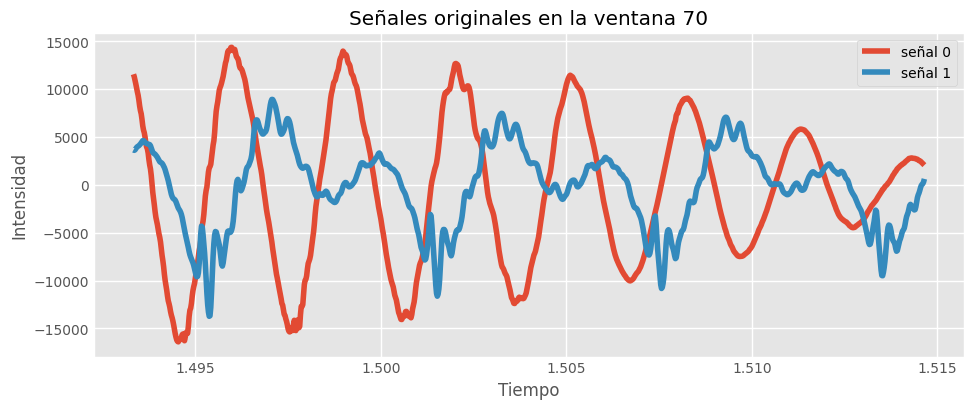

In [145]:
s1_AIRA=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/pristine_channel1.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]
s2_AIRA=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/pristine_channel2.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]



DOAS_AIRA=[-30,90]
N_mic_AIRA=3

freq_array_AIRA=arreglo_frecuencias(freq_sampleo=fr_AIRA,n_ventana=1024)
s_vec_AIRA=np.c_[s1_AIRA,s2_AIRA]

plt.title(f'Señales originales en la ventana {ventana_estudio}')
for i,si in enumerate(s_vec_AIRA.T):
    plt.plot(time_AIRA,si,label=f'señal {i}')
plt.xlabel('Tiempo');plt.ylabel('Intensidad');plt.legend();plt.show()

In [146]:
A_AIRA_mat=A_AIRA(DOAS_AIRA,freq_array_AIRA)
s_hat_vec_AIRA=fft.fft(s_vec_AIRA,axis=0)
x_mics_AIRA_señal=np.zeros((N_mic_AIRA,len(freq_array_AIRA)))+0j
for i in range(A_AIRA_mat.shape[0]):
    x_mics_AIRA_señal[:,i]=A_AIRA_mat[i,:,:]@s_hat_vec_AIRA[i,:]
x_mics_AIRA_señal=fft.ifft(x_mics_AIRA_señal,axis=1).real

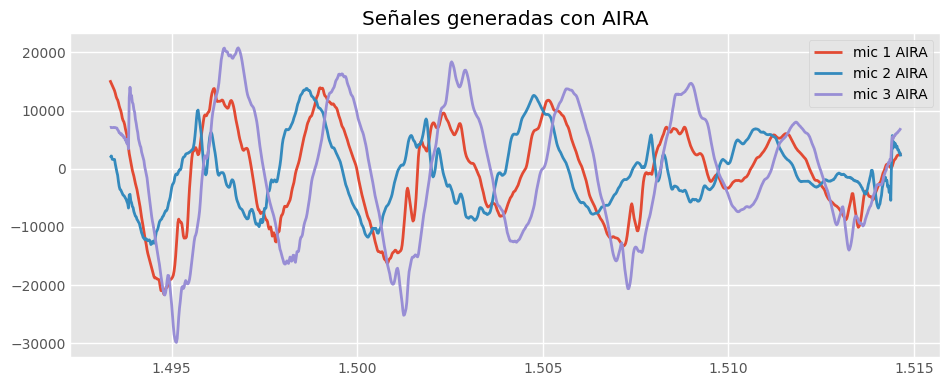

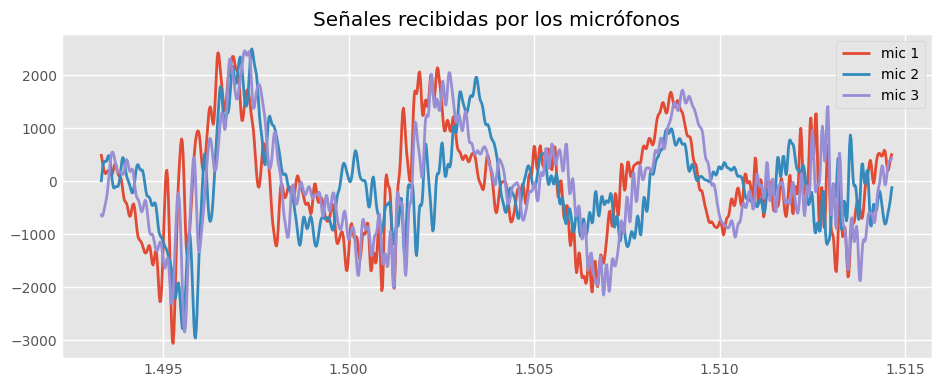

In [147]:

plt.plot(time_AIRA,x_mics_AIRA_señal[0],label='mic 1 AIRA',linewidth=2)
plt.plot(time_AIRA,x_mics_AIRA_señal[1],label='mic 2 AIRA',linewidth=2)
plt.plot(time_AIRA,x_mics_AIRA_señal[2],label='mic 3 AIRA',linewidth=2)
plt.title('Señales generadas con AIRA');plt.legend(); plt.show()

plt.plot(time_AIRA,lista_señales_AIRA[0],label='mic 1',linewidth=2)
plt.plot(time_AIRA,lista_señales_AIRA[1],label='mic 2',linewidth=2)
plt.plot(time_AIRA,lista_señales_AIRA[2],label='mic 3',linewidth=2)
plt.title('Señales recibidas por los micrófonos');plt.legend(); plt.show()

la diferencia con las señales de los micrófonos se debe a el ruido, reverb y la distancia? Cómo se podría emular esto para crear señales sintéticas y poder hacer experimentos con diferentes señales?

También se podría cambiar la frecuencia de una señal y ver si esto ayuda a mejorar el proceso de  DOA. Poner una de ellas muy aguda y la otra muy grave. 

## MUSIC con señal real

Redefinimos la función de MUSIC para que agarre el arreglo triangular de AIRA

In [148]:
def MUSIC_AIRA(this_ws,x_mics,angles,n_ruidoso):
    '''
    Función para encontrar el espectro de music. Depende del arreglo de micrófonos a través de A_completa
    x_mics: el arreglo de señales que ve cada micrófono
    '''
    X=fft.fft(x_mics,axis=1) # se hace la transformada a lo largo del eje 1 para obtener una transformada por cada mic
    music_spectrum=np.zeros(shape=(len(this_ws),len(angles)))
    for i,wi in enumerate(this_ws):
        this_X=X[:,wi] # Esta es la que tiene que ser calculada usando ventanas anteriores. Cuando dividas en varias ventanas de Hann, se debería de ver una diferencia en la estimación
        R=this_X.reshape(-1,1)*this_X.conj().T

        D,Q=np.linalg.eig(R)
        I=np.argsort(D.real)[::-1]
        D=D[I]
        Q=Q[:,I]


        # Qs=Q[:,1:n_ruidoso]
        Qn=Q[:,n_ruidoso:]

        A_angles=A_AIRA(θs=angles,freqs=[wi])

        for k in range(len(angles)):
            music_spectrum[i,k]=np.abs(1/(A_angles[0,:,k].conj().T@(Qn*Qn.conj().T@A_angles[0,:,k])))
    return music_spectrum


In [149]:
periodo_AIRA=n_ventana/fr_AIRA
this_ws_AIRA=np.arange(8,40,5)
freq_array_AIRA[this_ws_AIRA]
# frecuencias de la voz humana de 300 a 3000Hz

array([ 375.   ,  609.375,  843.75 , 1078.125, 1312.5  , 1546.875,
       1781.25 ])

In [150]:
x_mics_AIRA=np.array(lista_señales_AIRA)
n_ruidoso_AIRA=2
angles_AIRA=np.arange(-90,90,0.1) # Los ángulos para buscar ortogonalidad
music_spectrum_AIRA=MUSIC_AIRA(this_ws=this_ws_AIRA,x_mics= x_mics_AIRA,angles=angles_AIRA,n_ruidoso=n_ruidoso_AIRA)
music_plot(angles_AIRA,freq_array_AIRA,music_spectrum_AIRA,this_ws_AIRA,DOAS=DOAS_AIRA,titulo='MUSIC para arreglo triangular de AIRA con señales reales')

Hay que ver también el problema de la distancia entre micrófonos

descomposición generalizada de valor singular para hacerlo más rápido

Dejar las partes del cálculo de la matriz de covarianza y lo de eigenvectores como módulos para poder ponerlos mejor después.


# Usando la estimación de la matriz X

La matriz $X$ se está calculando paso a paso pero se puede estimar con los pasos anteriores a tavés de ![est](cov.png)